**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [436]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from collections import Counter
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [437]:
%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors=5, algorithm='brute', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y

    def neighbors(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def predict(self, X):
        if self.algorithm == 'kd_tree':
            sort_dist = KDTree(self.x_train).query(X, k=self.n_neighbors,
                                                   return_distance=False)
        else:
            dist = pairwise_distances(self.x_train, X, metric=self.metric).T
            sort_dist = np.argsort(dist, axis=1)[:, :self.n_neighbors:]
        num_test = sort_dist.shape[0]
        pred = np.zeros(num_test, dtype=int)
        for i in range(num_test):
            neighbors = self.y_train[sort_dist[i]].ravel()
            cntr = Counter(neighbors)
            pred[i] = cntr.most_common(1)[0][0]
        return pred

    def predict_proba(self, X):
        if self.algorithm == 'kd_tree':
            sort_dist = KDTree(self.x_train).query(X, k=self.n_neighbors,
                                                   return_distance=False)
        else:
            dist = pairwise_distances(self.x_train, X, metric=self.metric).T
            sort_dist = np.argsort(dist, axis=1)[:, :self.n_neighbors:]
        num_test = sort_dist.shape[0]
        cnt_cls = len(Counter(self.y_train))
        pred_proba = np.zeros(num_test * cnt_cls).reshape(num_test, cnt_cls)
        for i in range(num_test):
            neighbors = self.y_train[sort_dist[i]].ravel()
            cntr = list(Counter(neighbors).items())
            len_neighbors = len(cntr)
            for j in range(len_neighbors):
                pred_proba[i][cntr[j][0]] = cntr[j][1] / self.n_neighbors
        return pred_proba

    def score(self, X, y):
        return np.mean(np.array(self.predict(X)) == np.array(y))

54:1: W391 blank line at end of file


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [438]:
iris = datasets.load_iris()

In [439]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    test_size=0.1,
                                                    stratify=iris.target)

In [440]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [441]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [442]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [443]:
%time clf.fit(X_train, y_train)

CPU times: user 446 µs, sys: 72 µs, total: 518 µs
Wall time: 449 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [444]:
%time my_clf.fit(X_train, y_train)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 11 µs


In [445]:
%time clf.predict(X_test)

CPU times: user 2.53 ms, sys: 1.47 ms, total: 3.99 ms
Wall time: 2.64 ms


array([0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 2, 0, 2, 2, 2])

In [446]:
%time my_clf.predict(X_test)

CPU times: user 1.38 ms, sys: 567 µs, total: 1.94 ms
Wall time: 1.13 ms


array([0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 2, 0, 2, 2, 2])

In [447]:
%time clf.predict_proba(X_test)

CPU times: user 838 µs, sys: 317 µs, total: 1.15 ms
Wall time: 843 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [448]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.31 ms, sys: 473 µs, total: 1.78 ms
Wall time: 1e+03 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [449]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [450]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [451]:
%time clf.fit(X_train, y_train)

CPU times: user 622 µs, sys: 94 µs, total: 716 µs
Wall time: 642 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [452]:
%time my_clf.fit(X_train, y_train)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11 µs


In [453]:
%time clf.predict(X_test)

CPU times: user 2.16 ms, sys: 947 µs, total: 3.11 ms
Wall time: 2.29 ms


array([2, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0])

In [454]:
%time my_clf.predict(X_test)

CPU times: user 503 µs, sys: 22 µs, total: 525 µs
Wall time: 508 µs


array([2, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0])

In [455]:
%time clf.predict_proba(X_test)

CPU times: user 888 µs, sys: 149 µs, total: 1.04 ms
Wall time: 946 µs


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [456]:
%time my_clf.predict_proba(X_test)

CPU times: user 537 µs, sys: 28 µs, total: 565 µs
Wall time: 550 µs


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [457]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [458]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [459]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [460]:
def prep_text(data):
    data_new = []
    spc, a, z, asc_0, asc_9 = ord(' '), ord('a'), ord('z'), ord('0'), ord('9')
    for i in range(len(data)):
        tmp = data[i].lower()
        for j in range(len(data[i])):
            ch = ord(tmp[j])
            if not((ch == spc) or ((ch >= a) and (ch <= z))
                   or ((ch >= asc_0) and (ch <= asc_9))):
                tmp = tmp.replace(tmp[j], ' ')
        data_new.append(tmp)
    return data_new

In [461]:
data_new = prep_text(data)
data_tok = []
del_ind = []
for i in range(len(data_new)):
    line = data_new[i].split()
    if len(line) != 0:
        data_tok.append(line)
    else:
        del_ind.append(i)
# data_tok should be a list of lists of tokens for each line in data.

In [462]:
target = np.delete(target, del_ind)

In [463]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [464]:
d = {}
for text in data_tok:
    for term in text:
        if len(term) > 1:
            d[term] = 0

In [475]:
data = []
row = []
col = []


def update_ind(dict_value, row_ind):
    len_dict_value = len(dict_value)
    for i in range(len_dict_value):
        value = dict_value[i]
        if value != 0:
            data.append(value)
            col.append(i)
            row.append(row_ind)


def clear_value(text_dict):
    for key in text_dict:
        text_dict[key] = 0


i = 0
for text in data_tok:
    for term in text:
        if term in d:
            d[term] += 1
    d_value = list(d.values())
    update_ind(d_value, i)
    clear_value(d)
    i += 1

In [476]:
vec_feature = scipy.sparse.csr_matrix((data, (row, col)), dtype=float)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [367]:
%%pycodestyle
from sklearn.model_selection import cross_val_score

r1 = np.zeros(9)

for i in range(1, 10):
    clf1 = MyKNeighborsClassifier(n_neighbors=i, metric='euclidean')
    r1[i - 1] = cross_val_score(clf1, vec_feature, target, cv=3).mean()
    
r1

array([0.21428501, 0.21428501, 0.21783722, 0.21229755, 0.21184339,
       0.20648123, 0.20656943, 0.20811142, 0.20611237])

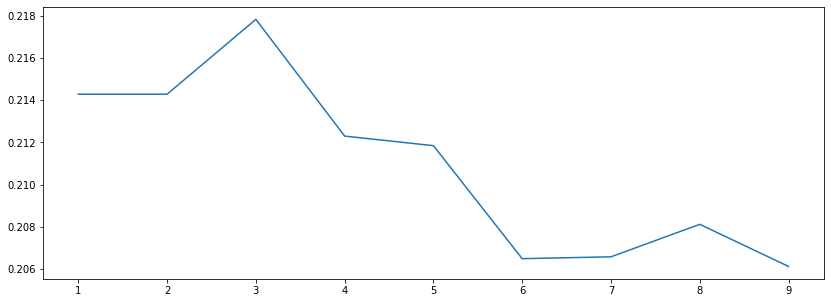

In [368]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot()
plt.plot(range(1, 10), r1)

#3 neighbors

In [477]:
r1.max()

0.21783722128969482

Косинусная метрика

In [369]:
r_cos = np.zeros(9)

for i in range(1, 10):
    clf_cos = MyKNeighborsClassifier(n_neighbors=i, metric='cosine')
    r_cos[i - 1] = cross_val_score(clf_cos, vec_feature, target, cv=3).mean()
    
r_cos

array([0.29843568, 0.29843568, 0.29234073, 0.28771406, 0.28326715,
       0.27862976, 0.2749936 , 0.26999628, 0.26672807])

/Users/vladimir/miniconda3/envs/technosphere/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


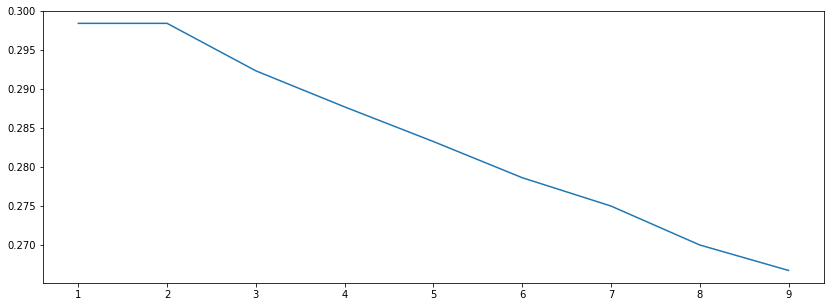

In [370]:
fig2 = plt.figure(figsize= (14,5))
ax11_2 = fig.add_subplot()
plt.plot(range(1, 10), r_cos)

In [378]:
r_cos.max()

#1 neighbor

0.29843568125968284

TfIdf преобразование

In [373]:
from sklearn.feature_extraction.text import TfidfTransformer

cls_tfldf = TfidfTransformer()
vec_feature_tfldf = cls_tfldf.fit_transform(vec_feature)

In [374]:
r_tfldf = np.zeros(9)

for i in range(1, 10):
    clf_tfl = MyKNeighborsClassifier(n_neighbors=i, metric='cosine')
    r_tfldf[i - 1] = cross_val_score(clf_tfl, vec_feature_tfldf, target, cv=3).mean()
    
r_tfldf

array([0.61279302, 0.61279302, 0.6136069 , 0.61606124, 0.61069841,
       0.60623521, 0.60223686, 0.60333161, 0.60187737])

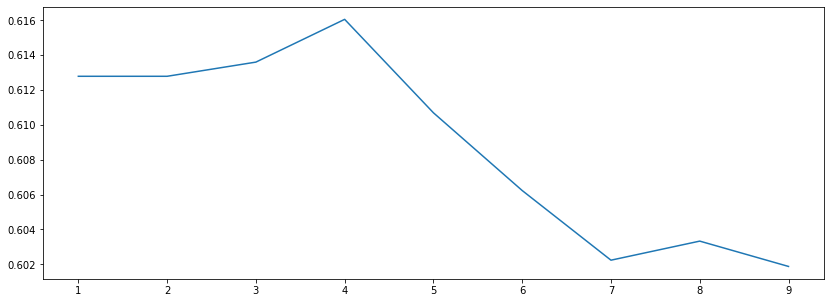

In [375]:
fig3 = plt.figure(figsize= (14,5))
ax11_3 = fig3.add_subplot()
plt.plot(range(1, 10), r_tfldf)

In [377]:
r_tfldf.max()

0.6160612368458539

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [379]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [380]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [381]:
data = newsgroups['data']
target = newsgroups['target']

data_test = newsgroups_test['data']
target_test = newsgroups_test['target']

In [382]:
data_new = prep_text(data)
data_tok = []
del_ind = []
for i in range (len(data_new)):
        l = data_new[i].split()
        if len(l) != 0:
            data_tok.append(data_new[i].split())
        else:
            del_ind.append(i)

In [383]:
data_new_test = prep_text(data_test)
data_tok_test = []
del_ind_test = []
for i in range (len(data_new_test)):
        l = data_new_test[i].split()
        if len(l) != 0:
            data_tok_test.append(data_new_test[i].split())
        else:
            del_ind_test.append(i)

In [384]:
target = np.delete(target, del_ind)
target_test = np.delete(target_test, del_ind_test)

In [385]:
d = {}
for text in data_tok:
    for term in text:
        d[term] = 0
        
for text in data_tok_test:
    for term in text:
        d[term] = 0


In [386]:
#Функции для создания data, row, col

def update_ind(dict_value, row_ind, data, row, col):
    len_dict_value = len(dict_value)
    for i in range(len_dict_value):
        value = dict_value[i]
        if value != 0:
            data.append(value)
            col.append(i)
            row.append(row_ind)

            
def clear_value(text_dict):
    for key in text_dict:
        text_dict[key] = 0
        

In [387]:
data = []
row = []
col = []
        
i = 0
for text in data_tok:
    for term in text:
        if term in d:
            d[term] += 1
    d_value = list(d.values())
    update_ind(d_value, i, data, row, col)
    clear_value(d)
    i += 1

In [388]:
data_test = []
row_test = []
col_test = []

i = 0
for text in data_tok_test:
    for term in text:
        if term in d:
            d[term] += 1
    d_value = list(d.values())
    update_ind(d_value, i, data_test, row_test, col_test)
    clear_value(d)
    i += 1
    


In [389]:
vec_feature = scipy.sparse.csr_matrix((data, (row, col)), dtype=float,
                                      shape=(len(data_tok), len(d)))
vec_feature_test = scipy.sparse.csr_matrix((data_test, (row_test, col_test)), dtype=float,
                                          shape=(len(data_tok_test), len(d)))

In [390]:
cls_tfldf = TfidfTransformer()
vec_feature = cls_tfldf.fit_transform(vec_feature)

cls_tfldf_test = TfidfTransformer()
vec_feature_test = cls_tfldf_test.fit_transform(vec_feature_test)

In [391]:
clf_main = MyKNeighborsClassifier(n_neighbors=2, metric='cosine')
clf_main.fit(vec_feature, target)
clf_main.score(vec_feature_test, target_test)

0.5141606238883568

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

На кросс-валидации максимум: 0.6040610802147726
На тесте: 0.5141606238883568

Отличается т.к. в тесте могут добавиться новые слова, которые будут увеличивать расстояние между текстами из тренировочной выборки, поэтому и увеличивается вероятность ошибиться при определение класса. По моему мнению, нужно брать такие тексты для тренировочной выборки, после которых, на тесте не будут встречаться новые значимые слова.